In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import time
np.random.seed(3)
import seaborn as sns
sns.set_theme(context='notebook')
import math

In [10]:
with open('classification.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)
X = (X-np.mean(X))/np.std(X) # NORMALIZING HERE
n, m = X.shape
split = int(0.8 * n)
p = np.random.permutation(n)
x_train = X[p[:split]]
y_train = y[p[:split]]
x_test = X[p[split:]]
y_test = y[p[split:]]

<h2>2 Accelerating K-Nearest Neighbour Classifier (13 points)
Load the dataset classification.npy, the dataset consists of over 100 predictors.

<h3>1. Implement the following versions of the Nearest Neighbour Classifier

<h1>a) Vanila KNN algorithm

In [11]:
def computeDistance(point1, point2, metric):
    # Euclidean distance
    if metric == 'euclidean':
        try:
            return np.sqrt(np.sum((point1 - point2)**2, axis=1))
        except:
            return np.sqrt(np.sum((point1 - point2)**2))

    # Cosine distance
    elif metric == 'cosine':
        return sum([a * b for a, b in zip(point1, point2)]) / np.sqrt(sum([a ** 2 for a in point1])) * np.sqrt(sum([b ** 2 for b in point2]))

    # City block distance
    elif metric == 'cityblock':
        return sum([abs(a - b) for a, b in zip(point1, point2)])


In [12]:
def vanilla_knn(x_train,y_train, x_test, k, metric):
    neighbors = []# This creates an empty list to store the nearest neighbors for each test data point
    for x in x_test:# This starts a loop that will iterate over each test data point
        distances = computeDistance(x,x_train, metric) # This calculates the distances between the test data point and all the training data points
        y_sorted = [y for _, y in sorted(zip(distances, y_train))]# This sorts the training labels by the calculated distances
        neighbors.append(y_sorted[:k])# This adds the k nearest neighbors to the list
    labels = [] # This creates an empty list to store the predicted labels for each test data point
    for nearest_neighbors in neighbors: # This starts a loop that will iterate over the list of nearest neighbors
        labels.append(max(set(nearest_neighbors), key=nearest_neighbors.count))# This predicts the label for the current test data point by selecting the most common label among its nearest neighbors
    return labels

def knn_accuracy(y_pred,y_test):
    # This function calculates the accuracy of a KNN model
    accuracy = sum(y_pred == y_test) / len(y_test)
    return accuracy

<h1>b) Partial Distances/Lower Bounding

In [13]:
# def partial_distance(x_train,y_train, query, k, metric):
#     distanceList = np.zeros(shape=(k,)) #array to capture distances
#     # Calculate the distance between the query point and the first k points in the training data
#     # Store the indices and distances in the distanceList array
#     for index, row in enumerate(x_train[:k,:]):
#         distanceList[index] = (index, computeDistance(query ,row, metric))
#     distanceList.sorted(distanceList, key=lambda x:x[1]) # Sort the distanceList array by distance
#     for index, row in enumerate(x_train[k:,:]): # Iterate through the remaining rows in the training data
#         d = 0
#         m = 1
#         # Initialize partial distance and the number of features used to calculate the partial distance
#         while m < x_train.shape[1] and d <  computeDistance(query[:m], row[:m], metric):
#             d += np.sum(np.square(query[:m] , row[:m]))
#             m += 1
#         # If the partial distance is less than the full distance, add the row to the distanceList
#         # and sort the distanceList array by distance
#         if d < computeDistance(query ,row, metric):
#             temp = distanceList.copy()
#             temp.append((index,d))
#             temp = sorted(temp, key=lambda x:x[1])
#             distanceList = temp[:-1]
#     k_nearest_class = y_train[[i[0] for i in distanceList]] # Get the classes of the k nearest neighbors
#     values, counts = np.unique(k_nearest_class, return_counts=True) # Count the number of occurrences of each class
#     predicted_class = values[np.argmax(counts)]
#     return predicted_class  

# def partial_knn(x_train, y_train, x_test, k, metric):
#     predicted = [] # Initialize a list to store the predicted classes for each row in the test data
#     for testRow in x_test:# Predict the class for the test row using the partial_distance function
#         pred_class = partial_distance(x_train, y_train, testRow, k, metric)
#         predicted.append(pred_class)
#     return predicted


In [14]:
def partial_distance(x_train,y_train, query, k, metric):
    # Initialize an array to store the indices and distances of the k nearest neighbors
    distanceList = np.zeros(shape=(k,), dtype='i,i')
    
    # Calculate the distance between the query point and the first k points in the training data
    # Store the indices and distances in the distanceList array
    for index, row in enumerate(x_train[:k,:]):
        distanceList[index] = (index, computeDistance(query ,row, metric))
        
    # Sort the distanceList array by distance
    distanceList = sorted(distanceList, key=lambda x:x[1])
    # Iterate through the remaining rows in the training data
    for index, row in enumerate(x_train[k:,:]):
        # Initialize partial distance and the number of features used to calculate the partial distance
        d = 0
        m = 1
        # Calculate the partial distance using the first m features
        # If the partial distance is less than the full distance, update the distance and increment m
        while m < x_train.shape[1] and d <  computeDistance(query[:m], row[:m], metric):
            d += np.sum(np.square(query[:m] , row[:m]))
            m += 1
        # If the partial distance is less than the full distance, add the row to the distanceList
        # and sort the distanceList array by distance
        if d < computeDistance(query ,row, metric):
            temp = distanceList.copy()
            temp.append((index,d))
            temp = sorted(temp, key=lambda x:x[1])
            distanceList = temp[:-1]
    # Get the classes of the k nearest neighbors
    k_nearest_class = y_train[[i[0] for i in distanceList]]
    # Count the number of occurrences of each class
    values, counts = np.unique(k_nearest_class, return_counts=True)
    # Return the class with the highest count as the predicted class for the query point
    predicted_class = values[np.argmax(counts)]
    return predicted_class  

def partial_knn(x_train, y_train, x_test, k, metric):
    # Initialize a list to store the predicted classes for each row in the test data
    predicted = []
    for testRow in x_test:# Iterate through each row in the test data
        # Predict the class for the test row using the partial_distance function
        pred_class = partial_distance(x_train, y_train, testRow, k, metric)
        # Append the predicted class to the list of predicted classes
        predicted.append(pred_class)
        
    # Return the list of predicted classes
    return predicted


<h1>c) Locality Sensitive Hashing

In [15]:
def similarity_hash(random_vector, observation):
    # Calculates dot product of random vector and observation
    dot_product = np.sum(random_vector * observation)
    sim_hash = ""
    # Adds '1' to the hash string if dot product is positive, '0' otherwise
    if dot_product > 0:
        sim_hash += '1'
    else:
        sim_hash += '0'
    return sim_hash

def create_and_populate_hashtables(inputs, num_tables):
    # Generates num_tables random hyperplanes
    hyperplane_vectors = np.random.randn(num_tables, len(inputs[0]))
    tables = []
    # Hashes each data point in inputs using the hyperplanes and stores the resulting hash in tables
    for data in inputs:
        hashValue = similarity_hash(hyperplane_vectors, data)
        tables.append(hashValue)
    return tables, hyperplane_vectors

def create_populate_hashtables(x_train, k):
    # Generates k random hyperplanes
    hyperplanes = np.random.randn(k, x_train.shape[1])
    hashtable = []
    # Hashes each training sample in x_train using the hyperplanes and stores the resulting hash in hashtable
    for trainRow in x_train:
        hash_val = similarity_hash(hyperplanes, trainRow)
        hashtable.append(hash_val)
    return hashtable, hyperplanes

def predict_class(x_train, y_train, testRow, hashtable, hyperplanes, metric):
    # Hash the validation row
    getHash = similarity_hash(hyperplanes, testRow)

    # Find all points in the hashtable that have the same hash value as the validation row
    nearest_neighbors = []
    for i, hash_val in enumerate(hashtable):
        if hash_val == getHash:
            nearest_neighbors.append(i)

    # If there are no points with the same hash value, return np.inf
    if len(nearest_neighbors) == 0:
        return np.inf

    # Otherwise, compute the distances from the validation row to the nearest neighbors
    distances = []
    for i in nearest_neighbors:
        distance = computeDistance(testRow, x_train[i], metric)
        distances.append(distance)

    # Find the index of the nearest neighbor
    min_index = np.argmin(distances)

    # Return the label of the nearest neighbor
    return y_train[nearest_neighbors[min_index]]

def lsh_knn(x_train, y_train, x_test, k, metric):
    # Generates k hash tables and the corresponding hyperplanes for the training data
    hashtable, hyperplanes = create_populate_hashtables(x_train, k)
    predicted_classes_val = []
    # Classifies each test sample using the hash tables and hyperplanes
    for testRow in x_test:
        val_predicted_class = predict_class(x_train, y_train, testRow, hashtable, hyperplanes, metric) # Predicting here
        predicted_classes_val.append(val_predicted_class)
    return predicted_classes_val


<h1>The following questions are answered cumulatively below:

<h3>2. Experiment with k = [1, 2, 3, 4, 5, 7] and report your accuracy on the test set.

<h3>Furthermore, report the runtime.

<h3>3. Experiment with distance=[cosine,euclidean,cityblock]. You can use scipy for the distance, report accuracy
on the test set

<h1>Euclidean

Algorithm: vanilla_knn Time for k: 1 is: 0.0977s Accuracy is: 59.5%
Algorithm: vanilla_knn Time for k: 2 is: 0.0875s Accuracy is: 54.5%
Algorithm: vanilla_knn Time for k: 3 is: 0.0871s Accuracy is: 60.5%
Algorithm: vanilla_knn Time for k: 4 is: 0.0876s Accuracy is: 58.0%
Algorithm: vanilla_knn Time for k: 5 is: 0.0875s Accuracy is: 59.5%
Algorithm: vanilla_knn Time for k: 6 is: 0.0875s Accuracy is: 61.5%
Algorithm: vanilla_knn Time for k: 7 is: 0.0880s Accuracy is: 58.5%

Algorithm: partial_knn Time for k: 1 is: 8.4379s Accuracy is: 36.0%
Algorithm: partial_knn Time for k: 2 is: 8.3197s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 3 is: 8.3187s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 4 is: 8.3093s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 5 is: 8.2340s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 6 is: 8.2250s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 7 is: 8.2240s Accuracy is: 37.0%

Algorithm: lsh_knn Time for k: 1 is: 0.5752s A

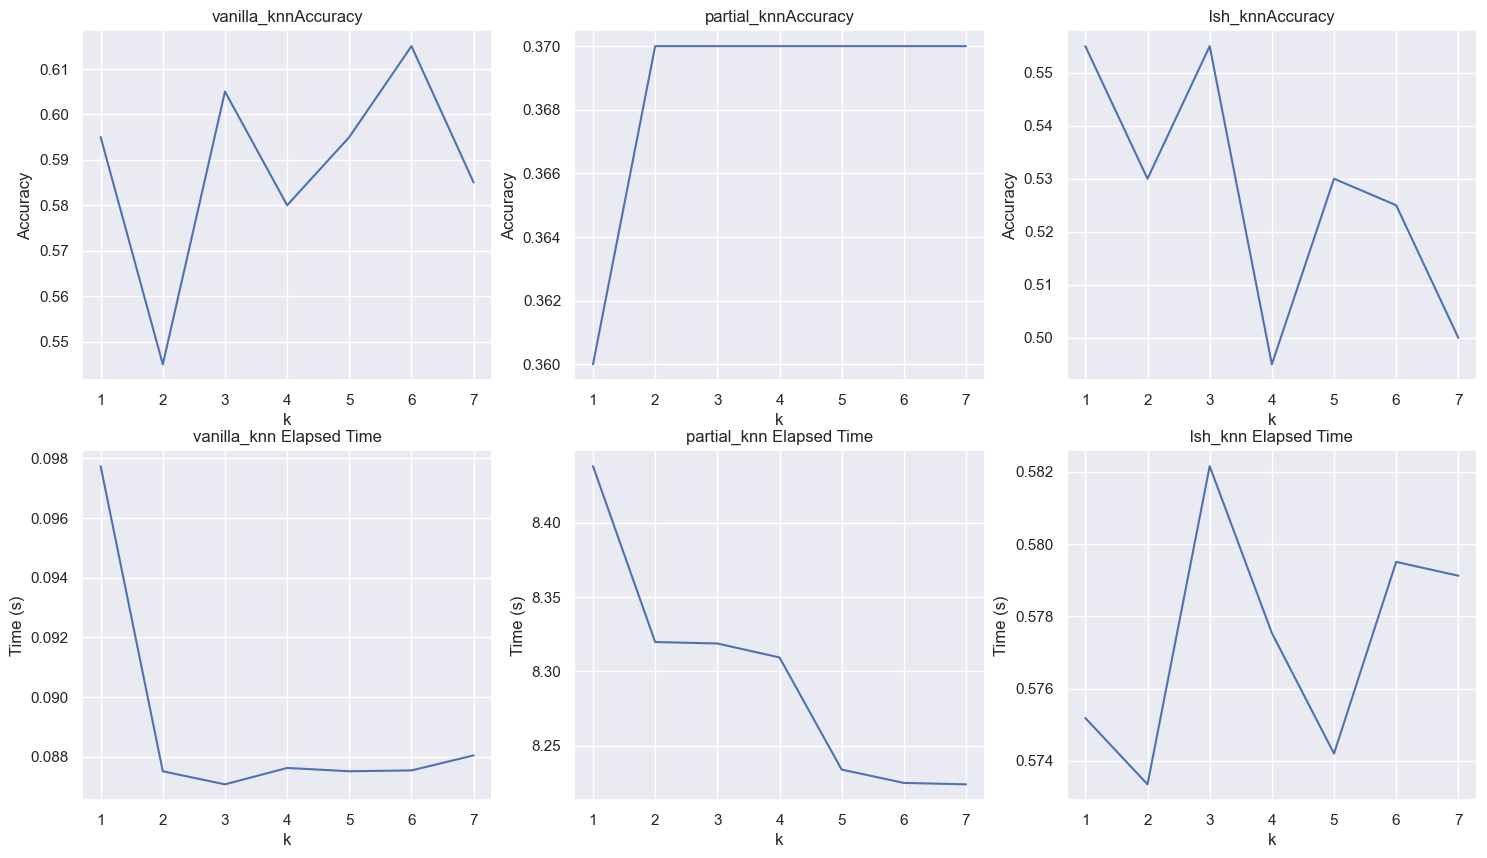

In [16]:
import sys
import matplotlib.pyplot as plt
import time

k = 7
metric = 'euclidean'

# list of function names
functions = ['vanilla_knn', 'partial_knn', 'lsh_knn']

# create a figure with subplots for the accuracy values and elapsed time values
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=len(functions), figsize=(18, 10))

# iterate over the functions
for i, f in enumerate(functions):
    # list to store the accuracy values for each k value
    accuracy_list = []
    # list to store the elapsed time values for each k value
    time_list = []
    
    # iterate over the k values
    for kval in range(1, k+1):
        # get the function object using the name
        func = getattr(sys.modules[__name__], f)
        
        # measure the elapsed time before calling the function
        start_time = time.perf_counter()
        
        # call the function with the required arguments
        predicted = func(x_train, y_train, x_test, kval, metric)
        
        # measure the elapsed time after calling the function
        end_time = time.perf_counter()
        
        # compute the elapsed time
        elapsed_time = end_time - start_time
        
        # compute the accuracy
        accuracy = knn_accuracy(predicted, y_test.ravel())
        
        # store the accuracy and elapsed time values
        accuracy_list.append(accuracy)
        time_list.append(elapsed_time)
        
        # print the elapsed time and accuracy
        print('Algorithm: {} Time for k: {} is: {:.4f}s Accuracy is: {}%'.format(f, kval, elapsed_time, np.round(accuracy*100, 4)))
    print()
    
    # plot the accuracy vs k values in the first set of subplots
    axes1[i].plot(range(1, k+1), accuracy_list)
    axes1[i].set_title(f+''+'Accuracy')
    axes1[i].set_xlabel('k')
    axes1[i].set_ylabel('Accuracy')
    
    # plot the elapsed time vs k values in the second set of subplots
    axes2[i].plot(range(1, k+1), time_list)
    axes2[i].set_title(f+' '+'Elapsed Time')
    axes2[i].set_xlabel('k')
    axes2[i].set_ylabel('Time (s)')

# show the plot
plt.show()


<h1>Cosine

Algorithm: vanilla_knn Time for k: 1 is: 0.2147s Accuracy is: 36.0%
Algorithm: vanilla_knn Time for k: 2 is: 0.2140s Accuracy is: 38.5%
Algorithm: vanilla_knn Time for k: 3 is: 0.2137s Accuracy is: 36.0%
Algorithm: vanilla_knn Time for k: 4 is: 0.2125s Accuracy is: 39.5%
Algorithm: vanilla_knn Time for k: 5 is: 0.2138s Accuracy is: 36.5%
Algorithm: vanilla_knn Time for k: 6 is: 0.2141s Accuracy is: 41.5%
Algorithm: vanilla_knn Time for k: 7 is: 0.2129s Accuracy is: 38.0%

Algorithm: partial_knn Time for k: 1 is: 9.2680s Accuracy is: 28.0%
Algorithm: partial_knn Time for k: 2 is: 9.2899s Accuracy is: 33.0%
Algorithm: partial_knn Time for k: 3 is: 9.2560s Accuracy is: 26.0%
Algorithm: partial_knn Time for k: 4 is: 9.2966s Accuracy is: 31.5%
Algorithm: partial_knn Time for k: 5 is: 9.3860s Accuracy is: 35.0%
Algorithm: partial_knn Time for k: 6 is: 9.4377s Accuracy is: 34.0%
Algorithm: partial_knn Time for k: 7 is: 9.4049s Accuracy is: 34.0%

Algorithm: lsh_knn Time for k: 1 is: 4.1039s A

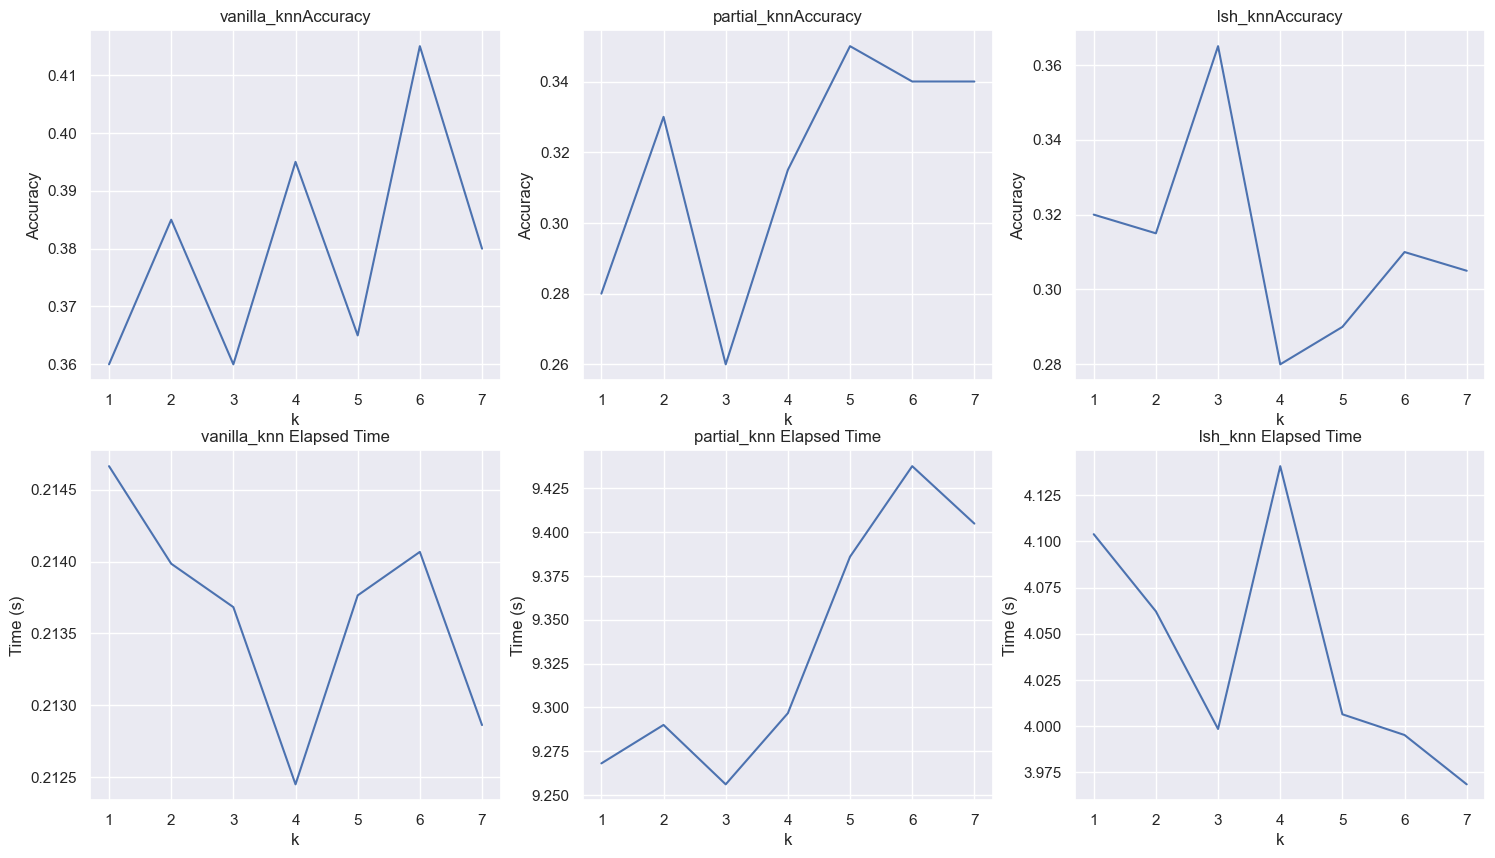

In [17]:
import sys
import matplotlib.pyplot as plt
import time

k = 7
metric = 'cosine'

# list of function names
functions = ['vanilla_knn', 'partial_knn', 'lsh_knn']

# create a figure with subplots for the accuracy values and elapsed time values
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=len(functions), figsize=(18, 10))

# iterate over the functions
for i, f in enumerate(functions):
    # list to store the accuracy values for each k value
    accuracy_list = []
    # list to store the elapsed time values for each k value
    time_list = []
    
    # iterate over the k values
    for kval in range(1, k+1):
        # get the function object using the name
        func = getattr(sys.modules[__name__], f)
        
        # measure the elapsed time before calling the function
        start_time = time.perf_counter()
        
        # call the function with the required arguments
        predicted = func(x_train, y_train, x_test, kval, metric)
        
        # measure the elapsed time after calling the function
        end_time = time.perf_counter()
        
        # compute the elapsed time
        elapsed_time = end_time - start_time
        
        # compute the accuracy
        accuracy = knn_accuracy(predicted, y_test.ravel())
        
        # store the accuracy and elapsed time values
        accuracy_list.append(accuracy)
        time_list.append(elapsed_time)
        
        # print the elapsed time and accuracy
        print('Algorithm: {} Time for k: {} is: {:.4f}s Accuracy is: {}%'.format(f, kval, elapsed_time, np.round(accuracy*100, 4)))
    print()
    
    # plot the accuracy vs k values in the first set of subplots
    axes1[i].plot(range(1, k+1), accuracy_list)
    axes1[i].set_title(f+''+'Accuracy')
    axes1[i].set_xlabel('k')
    axes1[i].set_ylabel('Accuracy')
    
    # plot the elapsed time vs k values in the second set of subplots
    axes2[i].plot(range(1, k+1), time_list)
    axes2[i].set_title(f+' '+'Elapsed Time')
    axes2[i].set_xlabel('k')
    axes2[i].set_ylabel('Time (s)')

# show the plot
plt.show()


<h1>Cityblock

Algorithm: vanilla_knn Time for k: 1 is: 0.0463s Accuracy is: 33.0%
Algorithm: vanilla_knn Time for k: 2 is: 0.0465s Accuracy is: 32.0%
Algorithm: vanilla_knn Time for k: 3 is: 0.0455s Accuracy is: 34.5%
Algorithm: vanilla_knn Time for k: 4 is: 0.0462s Accuracy is: 38.0%
Algorithm: vanilla_knn Time for k: 5 is: 0.0458s Accuracy is: 36.5%
Algorithm: vanilla_knn Time for k: 6 is: 0.0462s Accuracy is: 36.0%
Algorithm: vanilla_knn Time for k: 7 is: 0.0459s Accuracy is: 36.5%

Algorithm: partial_knn Time for k: 1 is: 7.7054s Accuracy is: 36.5%
Algorithm: partial_knn Time for k: 2 is: 7.7231s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 3 is: 7.7199s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 4 is: 7.7279s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 5 is: 8.0100s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 6 is: 7.7072s Accuracy is: 37.0%
Algorithm: partial_knn Time for k: 7 is: 7.7071s Accuracy is: 37.0%

Algorithm: lsh_knn Time for k: 1 is: 1.4735s A

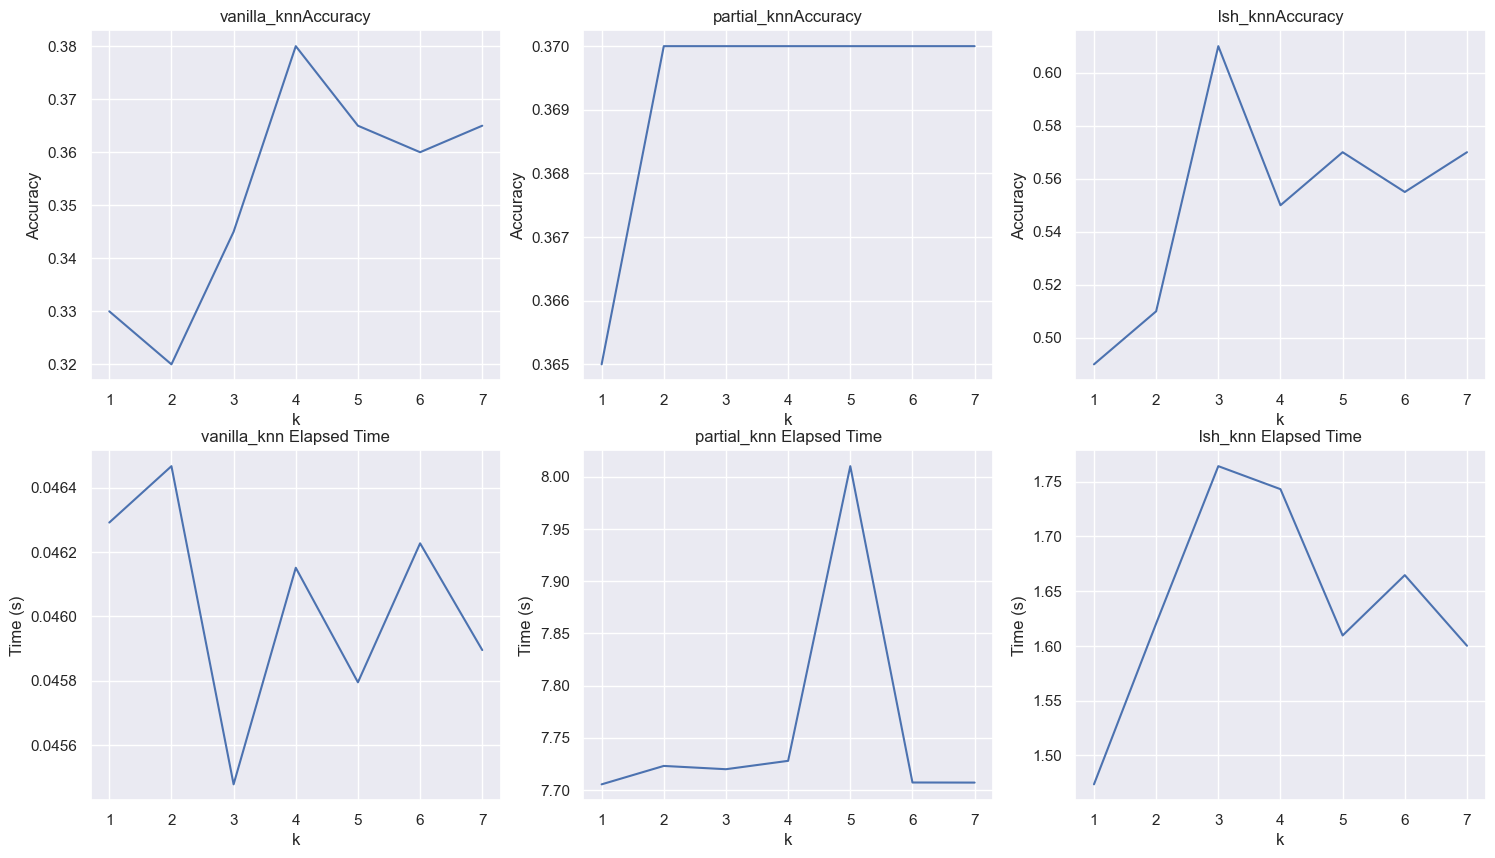

In [18]:
import sys
import matplotlib.pyplot as plt
import time

k = 7
metric = 'cityblock'

# list of function names
functions = ['vanilla_knn', 'partial_knn', 'lsh_knn']

# create a figure with subplots for the accuracy values and elapsed time values
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=len(functions), figsize=(18, 10))

# iterate over the functions
for i, f in enumerate(functions):
    # list to store the accuracy values for each k value
    accuracy_list = []
    # list to store the elapsed time values for each k value
    time_list = []
    
    # iterate over the k values
    for kval in range(1, k+1):
        # get the function object using the name
        func = getattr(sys.modules[__name__], f)
        
        # measure the elapsed time before calling the function
        start_time = time.perf_counter()
        
        # call the function with the required arguments
        predicted = func(x_train, y_train, x_test, kval, metric)
        
        # measure the elapsed time after calling the function
        end_time = time.perf_counter()
        
        # compute the elapsed time
        elapsed_time = end_time - start_time
        
        # compute the accuracy
        accuracy = knn_accuracy(predicted, y_test.ravel())
        
        # store the accuracy and elapsed time values
        accuracy_list.append(accuracy)
        time_list.append(elapsed_time)
        
        # print the elapsed time and accuracy
        print('Algorithm: {} Time for k: {} is: {:.4f}s Accuracy is: {}%'.format(f, kval, elapsed_time, np.round(accuracy*100, 4)))
    print()
    
    # plot the accuracy vs k values in the first set of subplots
    axes1[i].plot(range(1, k+1), accuracy_list)
    axes1[i].set_title(f+''+'Accuracy')
    axes1[i].set_xlabel('k')
    axes1[i].set_ylabel('Accuracy')
    
    # plot the elapsed time vs k values in the second set of subplots
    axes2[i].plot(range(1, k+1), time_list)
    axes2[i].set_title(f+' '+'Elapsed Time')
    axes2[i].set_xlabel('k')
    axes2[i].set_ylabel('Time (s)')

# show the plot
plt.show()


<h1>How is the NN algorithm different from the algorithms we have studied so far?

<h3><span style="color:blue">The k-nearest neighbors (k-NN) algorithm is a non-parametric method used for classification and regression. It is a lazy learning algorithm, meaning that it does not build a model ahead of time, but instead waits until a prediction is requested to find the nearest neighbors and make a prediction based on their values. Moreover, in KNN we do not train weights, rather the predictions are computed based on the values/classes of 'k' number of nearest neighbours</span>